In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.applications.vgg16 import decode_predictions
from keras import backend as K
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Reshape, Dense, Permute, multiply
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

import tensorflow as tf
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [2]:
#################################
####PRE_TRAINED VGG16############
#################################
og_model = VGG16(weights='imagenet', include_top=True)
#print(model.summary())
#tf.keras.utils.plot_model(model)
#3, 6, 10, 14, 18

In [3]:
#importing example image
#img_path = 'dog.jpg'
#img = image.load_img(img_path, target_size=(224, 224))
#print(img.size)
#x = image.img_to_array(img)
#x = np.expand_dims(x, axis=0)
#x = preprocess_input(x)


In [4]:
#Testing original model
imgs = ['dog.jpg', 'dog_2.jpg', 'dog_3.jpg']
for img_path in imgs:
    img = image.load_img(img_path, target_size=(224, 224))
    #print(img.size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    example = og_model.predict(x)
    print(np.argmax(example))
    label = decode_predictions(example)
    print(label[0][0])

217
('n02102040', 'English_springer', 0.9918467)
217
('n02102040', 'English_springer', 0.9045038)
217
('n02102040', 'English_springer', 0.82623065)


In [5]:
####################################
##########SENET BLOCK###############
####################################
def se_block(tensor, ratio=16):
    init = tensor
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    if K.image_data_format() == 'channels_first':
        se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x

In [6]:
#https://stackoverflow.com/questions/45306433/removing-then-inserting-a-new-middle-layer-in-a-keras-model

layers = [l for l in og_model.layers]

start = 7

print(layers[start - 1].output)

se_block = se_block(layers[start - 1].output, ratio = 16)


# Now stack everything back
# Note: If you are going to fine tune the model, do not forget to
#       mark other layers as un-trainable

x = se_block
for i in range(start, len(layers) - 1):
    layers[i].trainable = False
    print(layers[i])
    x = layers[i](x)    

x = Dense(10, activation='softmax', name='predictions')(x)

# Final touch
result_model = Model(layers[0].input, x)
result_model.compile(loss='categorical_crossentropy', optimizer='adam')

Tensor("block2_pool/MaxPool:0", shape=(None, 56, 56, 128), dtype=float32)


In [7]:
result_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
_______________________________________________________________________________________

In [8]:
# create a new generator
imagegen = ImageDataGenerator()
# load train data
train = imagegen.flow_from_directory("/home/tseibel/Desktop/imagenette2/train/", shuffle=False, batch_size=16, target_size=(224, 224))
# load val data
val = imagegen.flow_from_directory("/home/tseibel/Desktop/imagenette2/val/", shuffle=False, batch_size=16, target_size=(224, 224))

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


In [9]:
result_model.fit(train,validation_data = val , epochs=10)

Epoch 1/10
592/592 [==============================] - 73s 123ms/step - loss: 2.9980 - val_loss: 3.0719
Epoch 2/10
592/592 [==============================] - 74s 126ms/step - loss: 2.5082 - val_loss: 6.4531
Epoch 3/10
592/592 [==============================] - 76s 128ms/step - loss: 3.2800 - val_loss: 2.3820
Epoch 4/10
592/592 [==============================] - 75s 126ms/step - loss: 2.3128 - val_loss: 2.7433
Epoch 5/10
592/592 [==============================] - 75s 127ms/step - loss: 2.1550 - val_loss: 1.7390
Epoch 6/10
592/592 [==============================] - 76s 129ms/step - loss: 2.0168 - val_loss: 1.9496
Epoch 7/10
592/592 [==============================] - 76s 128ms/step - loss: 2.4790 - val_loss: 1.8625
Epoch 8/10
592/592 [==============================] - 76s 128ms/step - loss: 2.0998 - val_loss: 1.6243
Epoch 9/10
592/592 [==============================] - 76s 128ms/step - loss: 1.9460 - val_loss: 1.7791
Epoch 10/10
592/592 [==============================] - 76s 128ms/step - l

In [10]:
result_model.save('model_3_1_!')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_3_1_!/assets


In [12]:
imgs = ['dog.jpg', 'church.jpg','fish.jpg','gas.jpg','gball.jpg','horn.jpg','jump.jpg','saw.jpg','stereo.jpg','truck.jpg']
#imgs = ['dog.jpg', 'dog_2.jpg', 'dog_3.jpg']
#imgs = ['dog.jpg']
for img_path in imgs:
    img = image.load_img(img_path, target_size=(224, 224))
    print(img.size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    example = result_model.predict(x)
    print(example)
    print(np.argmax(example))

(224, 224)
[[4.9805573e-01 2.0311835e-01 3.0534496e-03 1.2419769e-01 3.2608819e-04
  2.5942043e-05 2.9593140e-05 4.6631732e-04 1.7014208e-01 5.8467319e-04]]
0
(224, 224)
[[0.06292667 0.03079848 0.01641037 0.4246382  0.27000836 0.08119959
  0.01391944 0.03257127 0.06582306 0.00170463]]
3
(224, 224)
[[1.9834687e-01 2.0848610e-03 2.4438705e-02 6.8141079e-01 1.9363152e-03
  5.7614674e-05 2.8229284e-04 2.1746517e-04 8.3389409e-02 7.8356862e-03]]
3
(224, 224)
[[0.06170408 0.00233982 0.02076257 0.29728705 0.01705444 0.01346499
  0.13449977 0.4470119  0.00419276 0.00168266]]
7
(224, 224)
[[1.8394859e-01 1.5240649e-02 2.7398447e-02 4.0370473e-01 6.2856433e-04
  4.5172055e-04 2.1152945e-04 6.5294438e-04 3.6483267e-01 2.9301418e-03]]
3
(224, 224)
[[0.13742681 0.34730557 0.02310513 0.4264255  0.00577768 0.00125422
  0.00475062 0.00586918 0.04722815 0.00085711]]
3
(224, 224)
[[0.05748309 0.2582615  0.02869308 0.46521604 0.00048268 0.00258103
  0.00170996 0.00786801 0.1734564  0.00424827]]
3
(224, 2

(1, 224, 224, 3)
1
(1, 224, 224, 64)
2
(1, 224, 224, 64)
3
(1, 112, 112, 64)
4
(1, 112, 112, 128)
5
(1, 112, 112, 128)
6
(1, 56, 56, 128)
7
(1, 128)
8
(1, 1, 1, 128)
9
(1, 1, 1, 8)
10
(1, 1, 1, 128)
11
(1, 56, 56, 128)
12
here


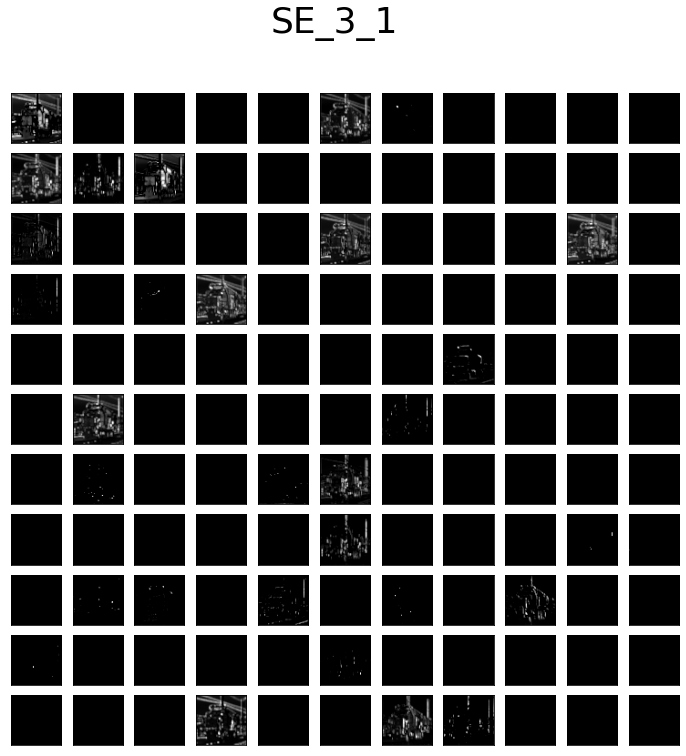

(1, 56, 56, 256)
13
(1, 56, 56, 256)
14
(1, 56, 56, 256)
15
(1, 28, 28, 256)
16
(1, 28, 28, 512)
17
(1, 28, 28, 512)
18
(1, 28, 28, 512)
19


In [13]:
import math

from matplotlib import pyplot

ixs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
outputs = [result_model.layers[i].output for i in ixs]
the_model = Model(inputs=result_model.input, outputs=outputs)

fmaps = the_model.predict(x)
count = 1
for fmap in fmaps:
    print(fmap.shape)
    print(count)
    if count == 12:
        print('here')
        square = int(math.sqrt(fmap.shape[3]+1))
        # plot all 64 maps in an 8x8 squares
        ix = 1
        #layer visualization
        pyplot.figure(figsize = (12,12))
        pyplot.suptitle('SE_3_1', fontsize=36)
        for _ in range(square):
            for _ in range(square):
                if ix > fmap.shape[3]:
                    continue
                # specify subplot and turn of axis
                ax = pyplot.subplot(square, square, ix)
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                pyplot.imshow(fmap[0,:, :, ix-1], cmap='gray')
                ix += 1
        # show the figure
        pyplot.show()
    count += 1

In [ ]:
#(i) the comparison between the classification results before and after the attention module
#(ii) each output of the feature maps after attention modules, 
    #e.g., how did the attention module change the output of the pooling before conv 2-1? conv 3-1? conv 4-1?, etc.
    
